<h1 style="color: #8A2BE2;"><center>Keras Timeseries Anomaly Detection</center></h1>

This Project is an adaptation of the following documentatio: https://keras.io/examples/timeseries/timeseries_anomaly_detection/

<h2 style="color: #8A2BE2;">Introduction</h2>

In [1]:
#install and import necessary packages

#Numerical arrays
import numpy as np

#Spreadsheet-like Data Frames 
import pandas as pd

#Neural Networks
import tensorflow.keras as keras

#Plotting
import matplotlib.pyplot as plt

## Data
https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

First let's define all the URLs we need to use

In [2]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

Next we can read in the datafile and create dataframes for small noise and daily jumpsup

In [5]:
# dataframe small noise taken from no_anomaly_url and set the timestamp column as the index
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [6]:
# print out the first 5 lines of the dataframe
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [7]:
# 
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [8]:
# 
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

In [9]:
# 
df_small_noise.iloc[0]['value']

18.3249185392

In [10]:
# 
df_small_noise.iloc[0].values[0]

18.3249185392

In [11]:
# 
df_small_noise.iloc[0].values[0] * 10e12

183249185392000.0

In [12]:
# 4032 values
df_small_noise.shape

(4032, 1)

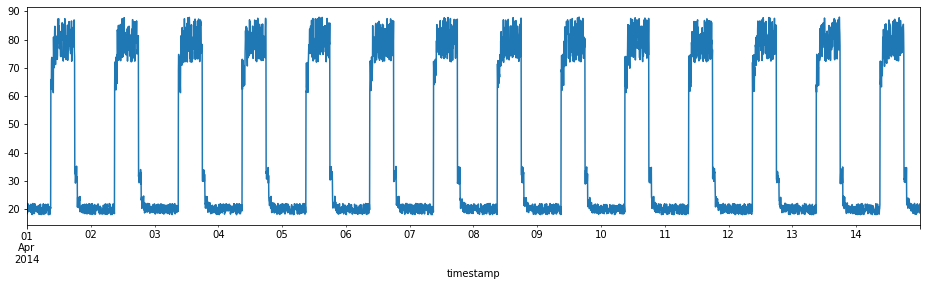

In [13]:
# Create a plot and set the size of the figure
fig, ax = plt.subplots(figsize=(16,4))

# Use pandas to plot small noise data frame and set legend to false
# ax=ax setting axes equal to the set of axes we created above using pyplot
# ";" gets rid of the return value of the function  
df_small_noise.plot(legend=False, ax=ax);

### Preprocessing

In [21]:
# 
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [22]:
# 
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

In [23]:
# 
df_train_vals = (df_small_noise - train_mean) / train_std

In [24]:
# 
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [25]:
# 
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [26]:
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [27]:
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [28]:
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

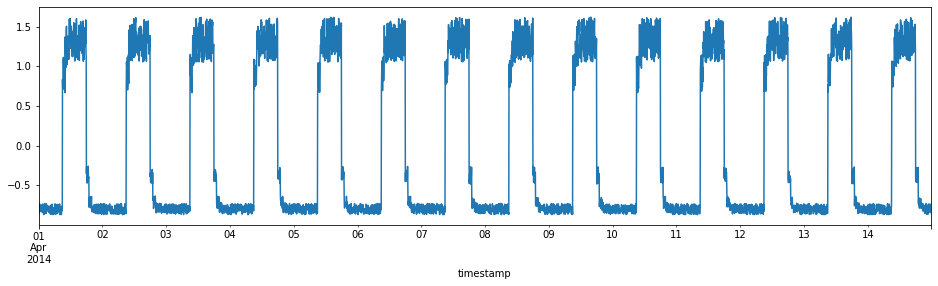

In [30]:
# 
fig, ax = plt.subplots(figsize=(16,4))

# Use pandas to plot data frame.
df_train_vals.plot(legend=False, ax=ax);

In [31]:
# 
df_train_vals.shape

(4032, 1)

In [32]:
# 
window_size = 288

Window example:

[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]<br>
window_size = 3 <br>
[1, 1, 2]<br>
[1, 2, 4]<br>
[2, 4, 5]<br>
[4, 5, 6]<br>
...


In [33]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
win_size = 3
# Length of L.
len(L)

12

In [34]:
# Number of windows from L.
len(L) - (win_size - 1)

10

In [35]:
# Remove brackets.
len(L) - win_size + 1

10

In [36]:
# Print the windows.
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])

[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


In [37]:
# For accumulating the windows.
wins = []

# Generate the windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

wins

[[1, 1, 2],
 [1, 2, 4],
 [2, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 1],
 [7, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5]]

In [38]:
# Create a 2D numpy array from wins.
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [39]:
# 
def windows(vals, N=window_size):
  # start with an empty list
  L = []
  # loop through all the possible windows
  for i in range(len(vals) - N + 1):
    # append window to the list
    L.append(vals[i:i+N])
  # Stack them all
  return np.stack(L)

In [40]:
# 
x_train = windows(df_train_vals)

In [41]:
# 
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [42]:
# 
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [43]:
# check 
x_train.shape

(3745, 288, 1)

We have 3745 training examples and windows of size 288. We have less values than we have windows in the array because the 288th element of the window eventually gets to the end of the array

In [44]:
#
df_train_vals['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

In [45]:
# 
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

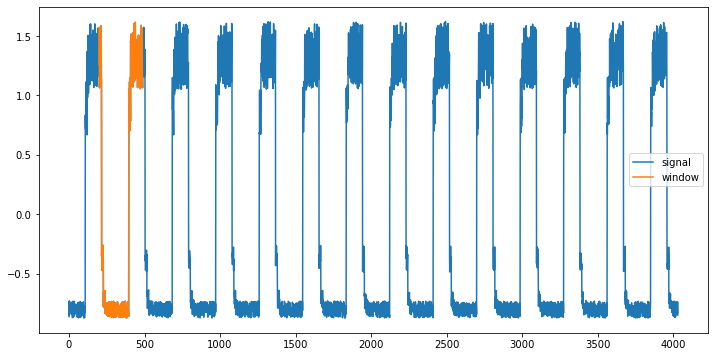

In [46]:
# 
window_no = 200

# 
fig, ax = plt.subplots(figsize=(12, 6))

# 
y = df_train_vals['value'].values

# 
ax.plot(np.arange(y.shape[0]), y, label='signal')

# The first window.
w = x_train[window_no].flatten()

# 
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

ax.legend();

## Neural Network
***

In [47]:
x_train.shape

(3745, 288, 1)

In [48]:
#
layers = [
  #
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  #
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [49]:
#
model = keras.Sequential(layers)

In [50]:
# 
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [51]:
# 
model.compile(optimizer=optimizer, loss="mse")

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [53]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 4s 88ms/step - loss: 0.4294 - val_loss: 0.0636
Epoch 2/50
27/27 [==============================] - 2s 78ms/step - loss: 0.0765 - val_loss: 0.0442
Epoch 3/50
27/27 [==============================] - 2s 84ms/step - loss: 0.0579 - val_loss: 0.0399
Epoch 4/50
27/27 [==============================] - 2s 88ms/step - loss: 0.0509 - val_loss: 0.0344
Epoch 5/50
27/27 [==============================] - 2s 82ms/step - loss: 0.0448 - val_loss: 0.0311
Epoch 6/50
27/27 [==============================] - 2s 81ms/step - loss: 0.0398 - val_loss: 0.0282
Epoch 7/50
27/27 [==============================] - 2s 82ms/step - loss: 0.0358 - val_loss: 0.0258
Epoch 8/50
27/27 [==============================] - 2s 81ms/step - loss: 0.0328 - val_loss: 0.0252
Epoch 9/50
27/27 [==============================] - 2s 87ms/step - loss: 0.0301 - val_loss: 0.0230
Epoch 10/50
27/27 [==============================] - 2s 86ms/step - loss: 0.0274 - val_loss: 0.0216
Epoch 11/

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [ ]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

<h2 style="color: #8A2BE2;">Conclusion</h2>

<h2 style="color: #8A2BE2;">Reference:</h2>

[1] https://keras.io/examples/timeseries/timeseries_anomaly_detection/